<div>
<img src='http://www.ic.uff.br/images/identidade_visual/Logo-Instituto-de-Computacao.png' width='20%' align='left'>
</div>

# `nsgaiii`: Understanding NSGA-III with a Python Implementation

## [Luis Martí](http://lmarti.com)

### [Institute of Computing](http://www.ic.uff.br) 

### [Universidade Federal Fluminense](http://www.uff.br)

In this notebook we will explore NSGA-III and introduce its implementation in Python, that is distributed as the [`nsgaiii` module](http://nsgaiii.github.com).

In [ ]:
import time, array, random, copy, math
from itertools import chain
from operator import attrgetter, itemgetter

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

In case you want to run this notebook on your own you need IPython and the DEAP library (https://www.github.com/DEAP/deap).

In [9]:
from deap import algorithms, base, benchmarks, tools, creator

In [2]:
from nsgaiii import *

In [ ]:
# %load nsgaiii/selection.py
#    This file is part of nsgaiii, a Python implementation of NSGA-III.
#
#    nsgaiii is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    nsgaiii is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with nsgaiii. If not, see <http://www.gnu.org/licenses/>.
#
#    by Luis Marti (IC/UFF) http://lmarti.com

import copy,random
import numpy as np
from deap import tools

class ReferencePoint(list):
    '''A reference point exists in objective space an has a set of individuals
    associated to it.'''
    def __init__(self, *args):
        list.__init__(self, *args)
        self.associations_count = 0
        self.associations = []

def generate_reference_points(num_objs, num_divisions_per_obj=4):
    '''Generates reference points for NSGA-III selection. This code is based on
    `jMetal NSGA-III implementation <https://github.com/jMetal/jMetal>`_.
    '''
    def gen_refs_recursive(work_point, num_objs, left, total, depth):
        if depth == num_objs - 1:
            work_point[depth] = left/total
            ref = ReferencePoint(copy.deepcopy(work_point))
            return [ref]
        else:
            res = []
            for i in range(left):
                work_point[depth] = i/total
                res = res + gen_refs_recursive(work_point, num_objs, left-i, total, depth+1)
            return res
    return gen_refs_recursive([0]*num_objs, num_objs, num_objs*num_divisions_per_obj,
                              num_objs*num_divisions_per_obj, 0)

def find_ideal_point(individuals):
    'Finds the ideal point from a set individuals.'
    current_ideal = [np.infty] * len(individuals[0].fitness.values)
    for ind in individuals:
        # Use wvalues to accomodate for maximization and minimization problems.
        current_ideal = np.minimum(current_ideal, ind.fitness.wvalues * -1)
    return current_ideal

def find_extreme_points(individuals):
    'Finds the individuals with extreme values for each objective function.'
    return [sorted(individuals, key=lambda ind:ind.fitness.wvalues[o] * -1)[-1]
            for o in range(len(individuals[0].fitness.values))]

def construct_hyperplane(individuals, extreme_points):
    'Calculates the axis intersects for a set of individuals and its extremes.'
    def has_duplicate_individuals(individuals):
        for i in range(len(individuals)):
            for j in range(i+1, len(individuals)):
                if individuals[i].fitness.values == individuals[j].fitness.values:
                    return True
        return False

    num_objs = len(individuals[0].fitness.values)

    if has_duplicate_individuals(extreme_points):
        intercepts = [extreme_points[m].fitness.values[m] for m in range(num_objs)]
    else:
        b = np.ones(num_objs)
        A = [point.fitness.values for point in extreme_points]
        x = np.linalg.solve(A,b)
        intercepts = 1/x
    return intercepts

def normalize_objective(individual, m, intercepts, ideal_point, epsilon=1e-20):
    'Normalizes an objective.'
    # Numeric trick present in JMetal implementation.
    if np.abs(intercepts[m]-ideal_point[m] > epsilon):
        return individual.fitness.values[m] / (intercepts[m]-ideal_point[m])
    else:
        return individual.fitness.values[m] / epsilon

def normalize_objectives(individuals, intercepts, ideal_point):
    '''Normalizes individuals using the hyperplane defined by the intercepts as
    reference. Corresponds to Algorithm 2 of Deb & Jain (2014).'''
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        ind.fitness.normalized_values = list([normalize_objective(ind, m,
                                                                  intercepts, ideal_point)
                                                                  for m in range(num_objs)])
    return individuals

def perpendicular_distance(direction, point):
    k = np.dot(direction, point) / np.sum(np.power(direction, 2))
    d = np.sum(np.power(np.subtract(np.multiply(direction, [k] * len(direction)), point) , 2))
    return np.sqrt(d)

def associate(individuals, reference_points):
    '''Associates individuals to reference points and calculates niche number.
    Corresponds to Algorithm 3 of Deb & Jain (2014).'''
    pareto_fronts = tools.sortLogNondominated(individuals, len(individuals))
    num_objs = len(individuals[0].fitness.values)

    for ind in individuals:
        rp_dists = [(rp, perpendicular_distance(ind.fitness.normalized_values, rp))
                    for rp in reference_points]
        best_rp, best_dist = sorted(rp_dists, key=lambda rpd:rpd[1])[0]
        ind.reference_point = best_rp
        ind.ref_point_distance = best_dist
        best_rp.associations_count +=1 # update de niche number
        best_rp.associations += [ind]

def niching_select(individuals, k):
    '''Secondary niched selection based on reference points. Corresponds to
    steps 13-17 of Algorithm 1 and to Algorithm 4.'''
    if len(individuals) == k:
        return individuals

    #individuals = copy.deepcopy(individuals)

    ideal_point = find_ideal_point(individuals)
    extremes = find_extreme_points(individuals)
    intercepts = construct_hyperplane(individuals, extremes)
    normalize_objectives(individuals, intercepts, ideal_point)

    reference_points = generate_reference_points(len(individuals[0].fitness.values))

    associate(individuals, reference_points)

    res = []
    while len(res) < k:
        min_assoc_rp = min(eference_points, key=lambda rp: rp.associations_count)
        min_assoc_rps = [rp for rp in reference_points if rp.associations_count == min_assoc_rp.associations_count]
        chosen_rp = min_assoc_rps[random.randint(0, len(min_assoc_rps)-1)]

        #print('Rps',min_assoc_rp.associations_count, chosen_rp.associations_count, len(min_assoc_rps))

        associated_inds = chosen_rp.associations

        if chosen_rp.associations:
            if chosen_rp.associations_count == 0:
                sel = min(chosen_rp.associations, key=lambda ind: ind.ref_point_distance)
            else:
                sel = chosen_rp.associations[random.randint(0, len(chosen_rp.associations)-1)]
            res += [sel]
            chosen_rp.associations.remove(sel)
            chosen_rp.associations_count += 1
            individuals.remove(sel)
        else:
            reference_points.remove(chosen_rp)
    return res

def sel_nsga_iii(individuals, k):
    '''Implements NSGA-III selection as described in
    Deb, K., & Jain, H. (2014). An Evolutionary Many-Objective Optimization
    Algorithm Using Reference-Point-Based Nondominated Sorting Approach,
    Part I: Solving Problems With BoxConstraints. IEEE Transactions on
    Evolutionary Computation, 18(4), 577–601. doi:10.1109/TEVC.2013.2281535.'''
    assert len(individuals) <= k

    if len(individuals)==k:
        return individuals

    # Algorithm 1 steps 4--8
    fronts = tools.sortLogNondominated(individuals, len(individuals))

    limit = 0
    res =[]
    for f, front in enumerate(fronts):
        res += front
        if len(res) > k:
            limit = f
            break
    # Algorithm 1 steps
    selection = []
    if limit > 0:
        for f in range(limit):
            selection += fronts[f]

    # complete selected inividuals using the referece point based approach
    selection += niching_select(fronts[limit], k - len(selection))
    return selection

__all__ = ["sel_nsga_iii"]


In [ ]:
generate_reference_points

For the first experiments we use DTLZ2, which is a reasonably simple problem, and 5 objectives.

$$f_5=\sum_i^\Omega x_i$$

In [11]:
creator.create("FitnessMin2", base.Fitness, weights=(-1.0,) * 2)
creator.create("FitnessMin3", base.Fitness, weights=(-1.0,) * 3)
creator.create("FitnessMin5", base.Fitness, weights=(-1.0,) * 5)

creator.create("Individual2", array.array, typecode='d', 
               fitness=creator.FitnessMin2)
creator.create("Individual3", array.array, typecode='d', 
               fitness=creator.FitnessMin3)
creator.create("Individual5", array.array, typecode='d', 
               fitness=creator.FitnessMin5)

The `toolbox` contains the configuration of the algorithm:
* how to create an individual,
* how to create a population,
* the evolutionary operators,
* etc.

The `stats` object describes the statistics we want to collect. For flexibility, we will store whole populations for every iteration.

Using DEAP is very simple to code a flexible NSGA-II whose internal functions can be modified via the `toolbox`.

In [12]:
number_of_variables = 30

In [13]:
BOUND_LOW, BOUND_UP = 0, 1

In [14]:
def calculate_pop_size(num_of_objs):
    return 10**(num_of_objs-1)

In [15]:
def create_problem_instance(problem_func, num_objs):
    return lambda ind: problem_func(ind, num_objs)

In [16]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [17]:
def prepare_toolbox(problem_instance, num_objs, selection_func):
    toolbox = base.Toolbox()
    
    toolbox.register('evaluate', problem_instance)
    toolbox.register('select', selection_func)
    
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, number_of_variables)
    
    if num_objs == 2:
        toolbox.register("individual", tools.initIterate, creator.Individual2, toolbox.attr_float)
    elif num_objs == 3:
        toolbox.register("individual", tools.initIterate, creator.Individual3, toolbox.attr_float)
    else:
        toolbox.register("individual", tools.initIterate, creator.Individual5, toolbox.attr_float)
        
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                 low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/number_of_variables)

    toolbox.pop_size = calculate_pop_size(num_objs)    # population size
    toolbox.max_gen = 200    # max number of iteration
    toolbox.mut_prob = 1/number_of_variables
    toolbox.cross_prob = 0.3
    
    return toolbox

In [18]:
toolbox = prepare_toolbox(lambda ind: benchmarks.dtlz2(ind, 3), 3, sel_nsga_iii)

In [19]:
pop = toolbox.population(n=20)

In [20]:
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

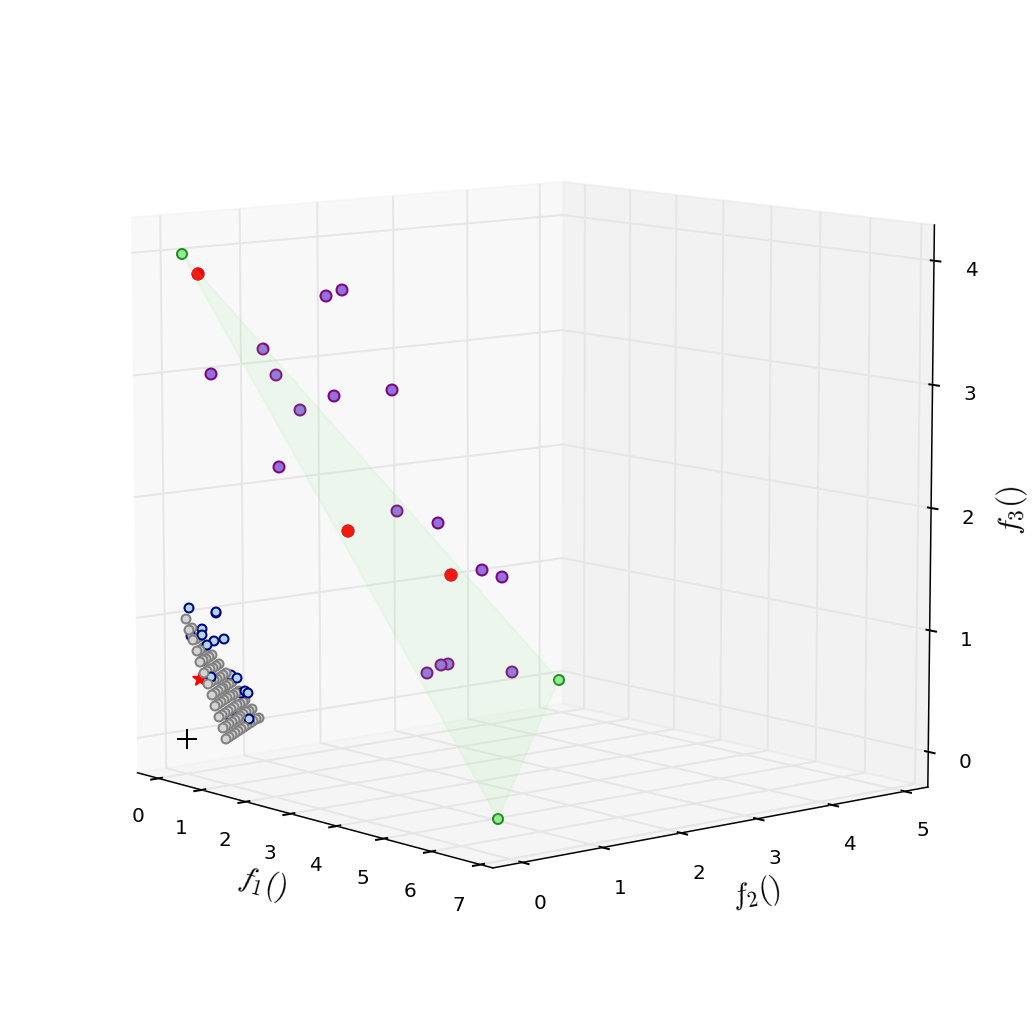

In [32]:
#from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin (black + sign)
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population (purple)
for ind in pop:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1], 
               ind.fitness.values[2], 
               color='purple', c='mediumpurple',
               s=30, marker='o')

# ideal point (red star)
ideal_point = find_ideal_point(pop)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*', color='red', c='red')

# extreme points marked (red)
extremes = find_extreme_points(pop)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1], 
               ex.fitness.values[2], s=30, c='r', marker='o', color='r')

# intercepts (in green)
intercepts = construct_hyperplane(pop, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2], c='lightgreen', color='forestgreen', s=100, marker='.')
    
tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives (light blue)
normalize_objectives(pop, intercepts, ideal_point)

for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='navy', marker='o', c='lightblue')

# reference points (gray)
rps = generate_reference_points(3)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray', color='gray')

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=9, azim=-40)
plt.autoscale(tight=True)

In [22]:
associate(pop, rps)

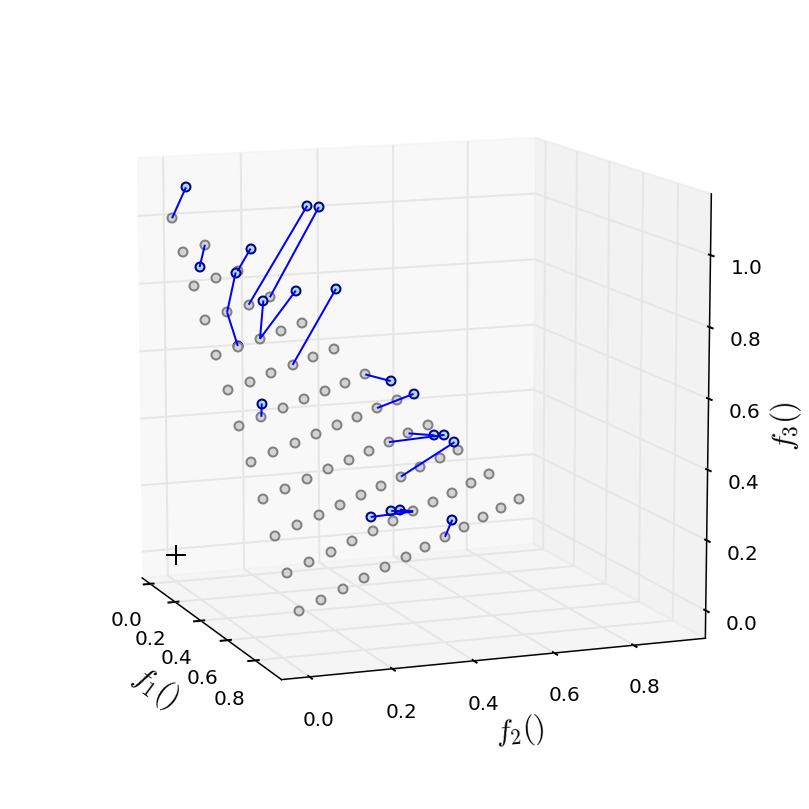

In [26]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
ax.scatter(0,0,0, c='k', marker='+', s=100)

for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray', color='gray')

pairs = []
for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2], color='navy', marker='o', c='lightblue')
    pairs += [(ind.fitness.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('blue')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

In [17]:
def nsga_iii(toolbox, stats=None, verbose=False):
    population = toolbox.population(n=toolbox.pop_size)
    return algorithms.eaMuPlusLambda(population, toolbox,
                              mu=toolbox.pop_size, 
                              lambda_=toolbox.pop_size, 
                              cxpb=toolbox.cross_prob, 
                              mutpb=toolbox.mut_prob,
                              ngen=toolbox.max_gen,
                              stats=stats, verbose=verbose
                             )

In [18]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [19]:
%time res, logbook = nsga_iii(toolbox, stats=stats)

CPU times: user 3min 13s, sys: 4.03 s, total: 3min 17s
Wall time: 3min 31s


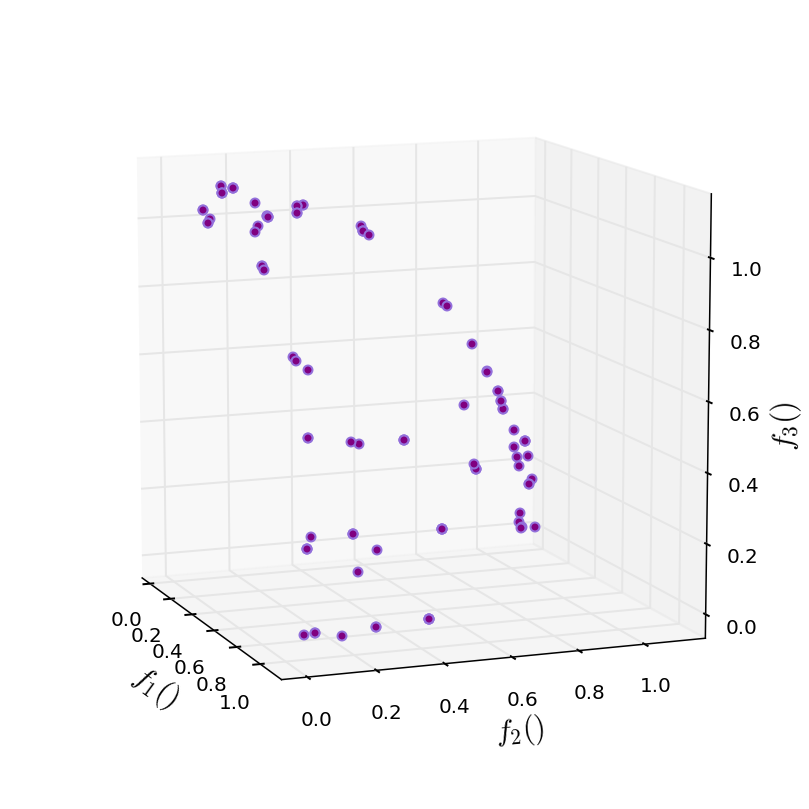

In [20]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for ind in res:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1],
               ind.fitness.values[2], c='purple', marker='o', color='mediumpurple')

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)

In [21]:
pops = logbook.select('pop')

In [22]:
from deap.tools._hypervolume import hv

In [23]:
def hypervolume(individuals, ref=None):
    front = tools.sortLogNondominated(individuals, len(individuals), first_front_only=True)
    wobjs = np.array([ind.fitness.wvalues for ind in front]) * -1
    if ref is None:
        ref = np.max(wobjs, axis=0) + 1
    return hv.hypervolume(wobjs, ref)

In [24]:
pops_obj = [np.array([ind.fitness.wvalues for ind in pop]) * -1 for pop in pops]

In [25]:
ref = np.max([np.max(wobjs, axis=0) for wobjs in pops_obj], axis=0) + 1

In [26]:
hypervols = [hypervolume(pop, ref) for pop in pops]

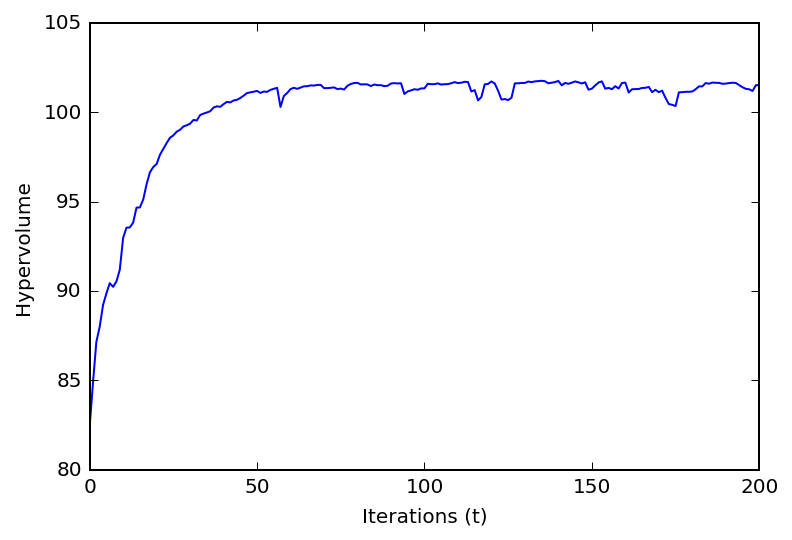

In [27]:
plt.plot(hypervols)
plt.xlabel('Iterations (t)')
plt.ylabel('Hypervolume')

In [28]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

# Load the example iris dataset
iris = sns.load_dataset("iris")

# "Melt" the dataset to "long-form" or "tidy" representation
iris = pd.melt(iris, "species", var_name="measurement")

/Users/lm/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [29]:
iris

,species,measurement,value
0,setosa,sepal_length,5.1
1,setosa,sepal_length,4.9
2,setosa,sepal_length,4.7
3,setosa,sepal_length,4.6
4,setosa,sepal_length,5.0
5,setosa,sepal_length,5.4
6,setosa,sepal_length,4.6
7,setosa,sepal_length,5.0
8,setosa,sepal_length,4.4
9,setosa,sepal_length,4.9


/Users/lm/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


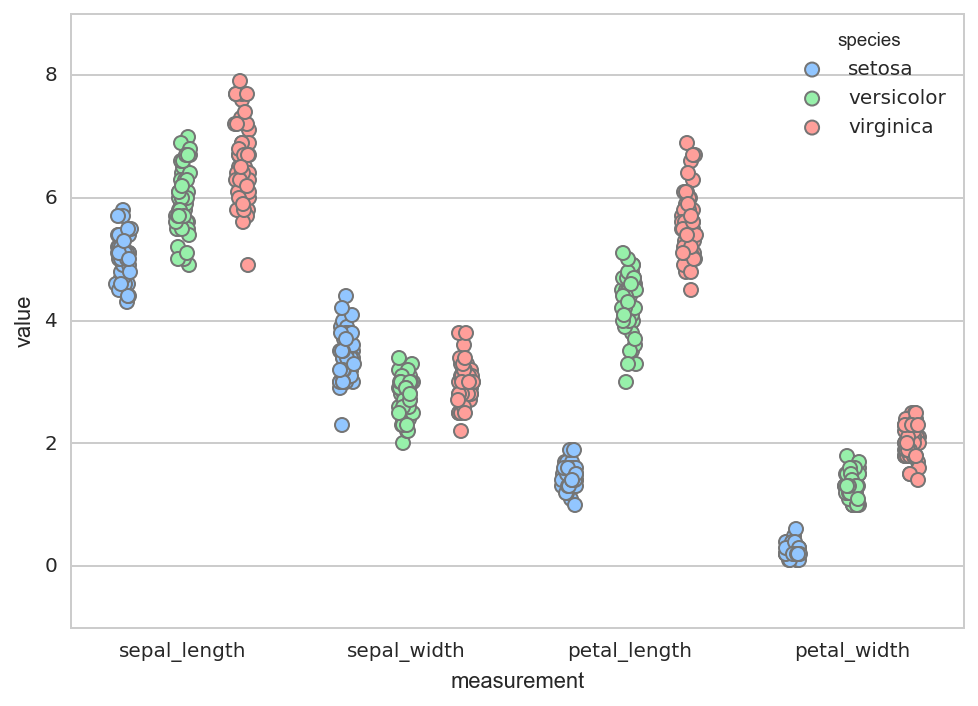

In [31]:
# Draw a categorical scatterplot to show each observation
sns.stripplot(x="measurement", y="value", hue="species", data=iris,
              jitter=True, edgecolor="gray")

In [38]:
from IPython.core.display import HTML
import urllib
HTML(str(urllib.request.urlopen('http://bit.ly/1Bf5Hft').read()))

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
@font-face {
    font-family: 'Optima';
    src: url('https://github.com/functional-koans/clojure-koans-web/blob/master/public/stylesheets/optima-webfont.eot?raw=true');
    src: url('https://github.com/functional-koans/clojure-koans-web/blob/master/public/stylesheets/optima-webfont.eot?raw=true?#iefix') format('embedded-opentype'),
         url('https://github.com/functional-koans/clojure-koans-web/blob/master/public/stylesheets/optima-webfont.woff?raw=true') format('woff'),
         url('https://github.com/functional-koans/clojure-koans-web/blob/master/public/stylesheets/optima-webfont.ttf?raw=true') format('truetype');
    font-weight: normal;
    font-style: normal;

}
.text_cell_render h1 {
    font-family: 'Optima', sans-serif;
    font-style:regular;
    font-weight: 200;
    text-align: left;
    font-size: 29pt;
    line-height: 100%;
    color:#000000;
    margin-bottom: 0.1em;
    margin-top: 0.5em;
    display: block;
}

div.text_cell_render{
    font-family: 'Optima', sans-serif;
    line-height: 120%;
    font-size: 125%;
    font-weight: 400;
    text-align: justify;
    margin-left:0em;
    margin-right:0em;
}
</style>
""")